# Function for Phase and detuning correction

In [ ]:
import numpy as np


def compute_phase_and_detuning_180Hz(pulse_train, fractions, pi_t = [23.76, 36.54, 106.33, 32.755, 39.168]):


    # A_60 ± ΔA_60: 0.000309 ± 0.000014
    # phi_60 ± Δphi_60: -0.613928 ± 0.045875
    # A_180 ± ΔA_180: 0.000067 ± 0.000014
    # phi_180 ± Δphi_180: 4.479853 ± 0.218467
    # Offset ± ΔOffset: 0.000253 ± 0.000010

    def line_signal(t, 
                    A1=0.000309, phi1=-0.613928,
                    A2=0.000067, phi2=4.479853,
                    offset=0.000253):
        return (
            2*np.pi*A1 * np.sin(2 * np.pi * 60 * t + phi1) +
            2*np.pi*A2 * np.sin(2 * np.pi * 180 * t + phi2) +
            offset
        ) - (
            2*np.pi*A1 * np.sin(2 * np.pi * 60 * 0 + phi1) +
            2*np.pi*A2 * np.sin(2 * np.pi * 180 * 0 + phi2) +
            offset
        )
    
    
    def analytical_integral(T, 
                    A1=0.000309, phi1=-0.613928,
                    A2=0.000067, phi2=4.479853,
                    offset=0.000253):
    
        int_60 = (A1 / 60) * (np.cos(phi1) - np.cos(2 * np.pi * 60 * T + phi1))
    
        int_180 = (A2 / 180) * (np.cos(phi2) - np.cos(2 * np.pi * 180 * T + phi2))
    
        t0 = (2 * np.pi * A1 * np.sin(2 * np.pi * 60 * 0 + phi1) +
              2 * np.pi * A2 * np.sin(2 * np.pi * 180 * 0 + phi2) +
              offset)
    
        int_offset = (offset - t0) * T
        return int_60 + int_180 + int_offset

    def compute_pi_times(pi_t):
        transition_strengths = np.loadtxt(
            'Z:\\Lab Data\\Phase_and_freq_correction_180Hz\\Transition_strengths_4p216.txt', delimiter=','
        )
        transition_strengths[transition_strengths == 0] = np.nan
    
        # pi_t = np.array([19.470, 35.554, 41.166, 30.108, 39.326])
        strengths = np.array([
            transition_strengths[23, 0], transition_strengths[14, 0],
            transition_strengths[17, 4], transition_strengths[16, 4], transition_strengths[15, 4]
        ])
    
        factors = np.array(pi_t) * strengths
        Fs = [1, 2, 3, 4]
        row_labels = [[i, i - j] for i in Fs for j in range(2 * i + 1)]
        col_labels = [-2, -1, 0, 1, 2]
    
        pi_times = np.zeros((24, 5))
        for i in range(np.shape(transition_strengths)[0]):
            for j in range(np.shape(transition_strengths)[1]):
                if not np.isnan(transition_strengths[i, j]):
                    delta_m = (row_labels[i][1] - col_labels[j]) + 2
                    pi_times[i, j] = factors[delta_m] / transition_strengths[i, j]
        
        return pi_times

    def get_pi_times(transitions,matrix):
        pi_times_list = []
        for transition in transitions:
            row_label = [transition[1],transition[2]]
            Fs = [1,2,3,4]
            states = []
            for i in Fs:
                for j in range(2*i+1):
                    mF = i-j
                    states.append([i,mF])
        
            row_labels = states
        
            col_label = transition[0]
        
            # Find the index of the row label
            row_index = next((i for i, label in enumerate(row_labels) if label == row_label), None)
            # Find the index of the column label
            col_index = col_labels.index(col_label)
            
            if row_index is not None and col_index in range(len(col_labels)):
                pi_times_list.append(matrix[row_index, col_index])
            else:
                pi_times_list.append(np.nan)
    
        return pi_times_list
    
    def get_pulse_schedule(rabi_freqs, fractions):
        if len(rabi_freqs) != len(fractions):
            raise ValueError(f"rabi_freqs {len(rabi_freqs)} and fractions {len(fractions)} must have the same length.")
        times = []
        t_current = 0.0  # start time in microseconds
        for Omega, frac in zip(rabi_freqs, fractions):
            if not 0 <= frac <= 1:
                raise ValueError(f"Fraction must be between 0 and 1, got {frac}.")
            # Calculate the rotation angle and pulse duration (in microseconds)
            theta = 2.0 * np.arcsin(np.sqrt(frac))
            t_pulse = theta / Omega if Omega > 0 else 0.0
            t_start = t_current
            t_end = t_current + t_pulse
            times.append((t_start, t_end))
            t_current = t_end
        return times

    pi_times_train = get_pi_times(pulse_train,compute_pi_times(pi_t))
    rabi_frequencis_list = np.pi/np.array(pi_times_train)

    sens_matrix = np.loadtxt('Z:\Lab Data\Phase_and_freq_correction_180Hz\sensitivities_4p216.txt',delimiter=',')
    sens_list = get_pi_times(pulse_train, sens_matrix)
    
    schedule = get_pulse_schedule(rabi_frequencis_list, fractions)
    pulses_sec = [(start * 1e-6, end * 1e-6) for (start, end) in schedule]
    # print(schedule)
    integrated_values = []
    detuning_values = []

    # For each pulse, compute the analytical integration and instantaneous detuning at the pulse start.
    for (start_s, _) in pulses_sec:
        integ = analytical_integral(start_s)
        integrated_values.append(integ)
        det = line_signal(start_s)
        detuning_values.append(det)
    
    # Convert to numpy arrays for vectorized operations.
    # print(integrated_values)
    integrated_values = np.array(integrated_values)
    detuning_values = np.array(detuning_values)
    sens_array = np.array(sens_list)
    
    # Compute phase (scaled integrated detuning) and instantaneous detuning.
    phase_180Hz = integrated_values * 1e6 * sens_array
    detuning_180Hz = detuning_values * sens_array
    
    return phase_180Hz, detuning_180Hz


In [70]:
import numpy as np

def compute_phase_and_detuning_180Hz(pulse_train, fractions, pi_t=[23.76, 36.54, 106.33, 32.755, 39.168]):
    def line_signal(t, 
                    A1=0.000309, phi1=-0.613928,
                    A2=0.000067, phi2=4.479853,
                    offset=0.000253):
        return (
            2*np.pi*A1 * np.sin(2 * np.pi * 60 * t + phi1) +
            2*np.pi*A2 * np.sin(2 * np.pi * 180 * t + phi2) +
            offset
        ) - (
            2*np.pi*A1 * np.sin(2 * np.pi * 60 * 0 + phi1) +
            2*np.pi*A2 * np.sin(2 * np.pi * 180 * 0 + phi2) +
            offset
        )
    
    def analytical_integral(T, 
                            A1=0.000309, phi1=-0.613928,
                            A2=0.000067, phi2=4.479853,
                            offset=0.000253):
        int_60 = (A1 / 60) * (np.cos(phi1) - np.cos(2 * np.pi * 60 * T + phi1))
        int_180 = (A2 / 180) * (np.cos(phi2) - np.cos(2 * np.pi * 180 * T + phi2))
        t0 = (2 * np.pi * A1 * np.sin(2 * np.pi * 60 * 0 + phi1) +
              2 * np.pi * A2 * np.sin(2 * np.pi * 180 * 0 + phi2) +
              offset)
        int_offset = (offset - t0) * T
        return int_60 + int_180 + int_offset

    def compute_pi_times(pi_t):
        transition_strengths = np.loadtxt(
            'Z:\\Lab Data\\Phase_and_freq_correction_180Hz\\Transition_strengths_4p216.txt', delimiter=','
        )
        transition_strengths[transition_strengths == 0] = np.nan
        strengths = np.array([
            transition_strengths[22, 1], transition_strengths[14, 0],
            transition_strengths[5, 2], transition_strengths[16, 4], transition_strengths[15, 4]
        ])
        factors = np.array(pi_t) * strengths
        Fs = [1, 2, 3, 4]
        row_labels = [[i, i - j] for i in Fs for j in range(2 * i + 1)]
        col_labels = [-2, -1, 0, 1, 2]
        pi_times = np.zeros((24, 5))
        for i in range(np.shape(transition_strengths)[0]):
            for j in range(np.shape(transition_strengths)[1]):
                if not np.isnan(transition_strengths[i, j]):
                    delta_m = (row_labels[i][1] - col_labels[j]) + 2
                    pi_times[i, j] = factors[delta_m] / transition_strengths[i, j]
        return pi_times

    def get_values_for_transitions(transitions, matrix, default_value=np.nan):
        Fs = [1, 2, 3, 4]
        states = []
        for i in Fs:
            for j in range(2 * i + 1):
                mF = i - j
                states.append([i, mF])
        row_labels = states
        col_labels = [-2, -1, 0, 1, 2]
        values = []
        for transition in transitions:
            if transition[0] == 0 and transition[1] == 0 and transition[2] == 0:
                values.append(default_value)
                continue
            row_label = [transition[1], transition[2]]
            col_label = transition[0]
            row_index = next((i for i, label in enumerate(row_labels) if label == row_label), None)
            col_index = col_labels.index(col_label) if col_label in col_labels else None
            if row_index is not None and col_index is not None:
                values.append(matrix[row_index, col_index])
            else:
                values.append(np.nan)
        return values

    def get_pulse_schedule(rabi_freqs, fractions):
        if len(rabi_freqs) != len(fractions):
            raise ValueError(f"rabi_freqs {len(rabi_freqs)} and fractions {len(fractions)} must have the same length.")
        times = []
        t_current = 0.0
        for Omega, frac in zip(rabi_freqs, fractions):
            if not 0 <= frac <= 1:
                raise ValueError(f"Fraction must be between 0 and 1, got {frac}.")
            theta = 2.0 * np.arcsin(np.sqrt(frac))
            t_pulse = theta / Omega if Omega > 0 else 0.0
            t_start = t_current
            t_end = t_current + t_pulse
            times.append((t_start, t_end))
            t_current = t_end
        return times

    pi_times_matrix = compute_pi_times(pi_t)
    pi_times_train = np.array(get_values_for_transitions(pulse_train, pi_times_matrix, default_value=np.nan), dtype=float)
    for i, tr in enumerate(pulse_train):
        if tr[0] == 0 and tr[1] == 0 and tr[2] == 0:
            pi_times_train[i] = 1e6

    rabi_frequencies_list = np.pi / pi_times_train

    sens_matrix = np.loadtxt('Z:\\Lab Data\\Phase_and_freq_correction_180Hz\\sensitivities_4p216.txt', delimiter=',')
    sens_list = np.array(get_values_for_transitions(pulse_train, sens_matrix, default_value=0.0), dtype=float)
    for i, tr in enumerate(pulse_train):
        if tr[0] == 0 and tr[1] == 0 and tr[2] == 0:
            sens_list[i] = 0.0

    schedule = get_pulse_schedule(rabi_frequencies_list, fractions)
    pulses_sec = [(start * 1e-6, end * 1e-6) for (start, end) in schedule]
    print(pulses_sec)
    integrated_values = []
    detuning_values = []

    for (start_s, _) in pulses_sec:
        integ = analytical_integral(start_s)
        integrated_values.append(integ)
        det = line_signal(start_s)
        print(det)
        detuning_values.append(det)

    integrated_values = np.array(integrated_values)
    detuning_values = np.array(detuning_values)
    sens_array = np.array(sens_list)

    phase_180Hz = integrated_values * 1e6 * sens_array
    detuning_180Hz = detuning_values * sens_array

    return phase_180Hz, detuning_180Hz


In [71]:
pulse_train = [[0,0,0], [-1,4,-3], [0,0,0], [-1,4,-3]]

fractions = [(np.sin((100/1e6)*(np.pi/2)))**2, 0.5, (np.sin((100/1e6)*(np.pi/2)))**2, 0.5]

detuning_180Hz, phase_180Hz = compute_phase_and_detuning_180Hz(pulse_train, fractions)
print(detuning_180Hz[1:])
print(phase_180Hz)

[(0.0, np.float64(9.999999999999998e-05)), (np.float64(9.999999999999998e-05), np.float64(0.00011187999999999999)), (np.float64(0.00011187999999999999), np.float64(0.00021187999999999998)), (np.float64(0.00021187999999999998), np.float64(0.00022375999999999999))]
0.0
5.227655348674317e-05
5.8942158465998765e-05
0.00011887371208924805
[-0.00894677  0.         -0.04217021]
[ 0.         -0.00018293  0.         -0.00041597]


# Simulator 

## Transition strength

In [ ]:
import sys
import os
import numpy as np

solver_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'Hamiltonian_Solver'))
if solver_path not in sys.path:
    sys.path.append(solver_path)

import Hamiltonian_solver as hs

transition_strengths = hs.TransitionStrength(4.2075)
trans_strength_F2 = transition_strengths[:,3:]
trans_strength_F2[trans_strength_F2 == 0] = np.nan
print(trans_strength_F2)


[[       nan 0.05632536 0.05500008 0.05188068 0.0340726 ]
 [0.07523414 0.02457179 0.00959647 0.03360083 0.05602814]
 [0.05298793 0.05980028 0.04697682 0.03553814        nan]
 [       nan        nan 0.11030296 0.10614012 0.08193992]
 [       nan 0.12731901 0.02754755 0.06123282 0.09810004]
 [0.09731466 0.06349494 0.09191825 0.02583329 0.09322989]
 [0.11625868 0.02819404 0.05749295 0.10701465        nan]
 [0.11047966 0.10560798 0.08141095        nan        nan]
 [       nan        nan        nan 0.28134277 0.00907213]
 [       nan        nan 0.22882725 0.15490602 0.04150275]
 [       nan 0.15172072 0.213463   0.06966248 0.04457956]
 [0.07631055 0.20082974 0.1740344  0.00305674 0.03589053]
 [0.13668241 0.23513385 0.07722692 0.03897756        nan]
 [0.22409175 0.1762385  0.0105869         nan        nan]
 [0.26801156 0.06338593        nan        nan        nan]
 [       nan        nan        nan        nan 0.32779429]
 [       nan        nan        nan 0.08278136 0.26802286]
 [       nan  

## Magnetic field sensitivity

In [12]:
sensitivity_matrix = hs.generate_magnetic_field_sensitivity(4.2075)
sensitivity_matrix[np.isnan(trans_strength_F2)] = np.nan

print(np.round(sensitivity_matrix, 4))

[[    nan  3.8701  3.1686  2.4681  1.7687]
 [ 1.746   1.0435  0.342  -0.3584 -1.0579]
 [-1.2436 -1.9462 -2.6477 -3.3481     nan]
 [    nan     nan  3.257   2.5566  1.8571]
 [    nan  2.3057  1.6042  0.9037  0.2043]
 [ 1.4041  0.7015  0.     -0.7004 -1.3999]
 [-0.114  -0.8165 -1.518  -2.2185     nan]
 [-1.4729 -2.1754 -2.8769     nan     nan]
 [    nan     nan     nan  3.4963  2.7969]
 [    nan     nan  3.2015  2.5011  1.8016]
 [    nan  2.84    2.1385  1.4381  0.7386]
 [ 2.4406  1.7381  1.0366  0.3361 -0.3633]
 [ 1.307   0.6045 -0.097  -0.7975     nan]
 [ 0.1333 -0.5692 -1.2707     nan     nan]
 [-1.1211 -1.8236     nan     nan     nan]
 [    nan     nan     nan     nan  2.7992]
 [    nan     nan     nan  1.8204  1.121 ]
 [    nan     nan  1.0969  0.3964 -0.303 ]
 [    nan  0.5028 -0.1987 -0.8992 -1.5986]
 [ 0.0172 -0.6854 -1.3869 -2.0873 -2.7868]
 [-1.0623 -1.7648 -2.4663 -3.1668     nan]
 [-2.0162 -2.7187 -3.4202     nan     nan]
 [-2.7967 -3.4992     nan     nan     nan]
 [-2.7992  

## Helper functions

In [33]:
import numpy as np 
from scipy.io import loadmat
transition_strengths = np.array([[np.nan, 0.0563, 0.055, 0.0519, 0.0341],
                        [0.0753, 0.0246, 0.0096, 0.0336, 0.056],
                        [0.053, 0.0598, 0.047, 0.0355, np.nan],
                        [np.nan, np.nan, 0.1103, 0.1061, 0.0819],
                        [np.nan, 0.1273, 0.0275, 0.0613, 0.0981],
                        [0.0973, 0.0635, 0.0919, 0.0258, 0.0932],
                        [0.1163, 0.0281, 0.0575, 0.107, np.nan],
                        [0.1105, 0.1056, 0.0814, np.nan, np.nan],
                        [np.nan, np.nan, np.nan, 0.2813, 0.0091],
                        [np.nan, np.nan, 0.2288, 0.1549, 0.0415],
                        [np.nan, 0.1517, 0.2135, 0.0697, 0.0446],
                        [0.0763, 0.2008, 0.1741, 0.003, 0.0359],
                        [0.1367, 0.2351, 0.0773, 0.039, np.nan],
                        [0.2241, 0.1763, 0.0106, np.nan, np.nan],
                        [0.268, 0.0634, np.nan, np.nan, np.nan],
                        [np.nan, np.nan, np.nan, np.nan, 0.3278],
                        [np.nan, np.nan, np.nan, 0.0828, 0.268],
                        [np.nan, np.nan, 0.0019, 0.1664, 0.234],
                        [np.nan, 0.025, 0.0679, 0.2278, 0.1523],
                        [0.0232, 0.001, 0.156, 0.2077, 0.0915],
                        [0.0309, 0.0593, 0.206, 0.1694, np.nan],
                        [0.0276, 0.1438, 0.2401, np.nan, np.nan],
                        [0.0094, 0.2862, np.nan, np.nan, np.nan],
                        [0.3278, np.nan, np.nan, np.nan, np.nan]])

import numpy as np

transition_strengths = np.loadtxt('Z:\Lab Data\Phase_and_freq_correction_180Hz\Transition_strengths_4p216.txt',delimiter=',')  # Assumes space-delimited file
transition_strengths[transition_strengths == 0] = np.nan
# print(transition_strengths)


pi_t = [13.485, 23.734, 27.053, 20.662, 26.575]
strengths = np.array([transition_strengths[23,0],transition_strengths[14,0],transition_strengths[17,4],transition_strengths[16,4],transition_strengths[15,4]])
pitime_n2 = pi_t[0] # [-2, 4, -4]
pitime_n1 = pi_t[1] # [-2, 3, -3]
pitime_0 = pi_t[2] # [2, 4, 2]
pitime_p1 = pi_t[3] # [2, 4, 3]
pitime_p2 = pi_t[4] # [2, 4, 4]

pi_t = np.array([pitime_n2,pitime_n1,pitime_0,pitime_p1,pitime_p2])
factors = pi_t * strengths
Fs = [1,2,3,4]
row_labels = []
for i in Fs:
    for j in range(2*i+1):
        mF = i-j
        row_labels.append([i,mF])
col_labels = [-2, -1, 0, 1, 2]

pi_times = np.zeros((24,5))
for i in range(np.shape(transition_strengths)[0]):
    for j in range(np.shape(transition_strengths)[1]):
        # print(i,j)
        if not np.isnan(transition_strengths[i,j]):

            delta_m = (row_labels[i][1]-col_labels[j])+2

            pi_times[i,j] = factors[delta_m]/transition_strengths[i,j]
print(pi_times)
def get_pi_times(transitions,matrix = pi_times):
    pi_times_list = []
    for transition in transitions:
        if transition[1] == 0 and transition[2] == 0:
            pi_times_list.append(np.nan)
            continue
        row_label = [transition[1],transition[2]]
        Fs = [1,2,3,4]
        states = []
        for i in Fs:
            for j in range(2*i+1):
                mF = i-j
                states.append([i,mF])
    
        row_labels = states
    
        col_label = transition[0]
    
        # Find the index of the row label
        row_index = next((i for i, label in enumerate(row_labels) if label == row_label), None)
        # Find the index of the column label
        col_index = col_labels.index(col_label)
        
        if row_index is not None and col_index in range(len(col_labels)):
            pi_times_list.append(matrix[row_index, col_index])
        else:
            pi_times_list.append(np.nan)

    return pi_times_list

def get_pulse_schedule(rabi_freqs, fractions):
    if len(rabi_freqs) != len(fractions):
        raise ValueError("rabi_freqs and fractions must have the same length.")
    
    times = []
    t_current = 0.0  # microseconds (start at time=0)
    
    for Omega, frac in zip(rabi_freqs, fractions):
        if not 0 <= frac <= 1:
            t_pulse = frac
        else:
            theta = 2.0 * np.arcsin(np.sqrt(frac))   # in radians
            t_pulse = theta / Omega if Omega > 0 else 0.0  # microseconds (if Omega in MHz)
        
        # The pulse starts at t_current, ends at t_current + t_pulse
        t_start = t_current
        t_end = t_current + t_pulse
        
        times.append((t_start, t_end))
        t_current = t_end  # next pulse starts after this one finishes
    
    return times

sens_matrix = np.loadtxt('Z:\Lab Data\Phase_and_freq_correction_180Hz\sensitivities_4p216.txt',delimiter=',')
print(np.round(sens_matrix,5))
# print(matrix_sen_24x5)

[[   0.          154.60483534  100.68064091  122.03471628  186.77066934]
 [ 115.75724783  225.49215483  658.34225266  189.28006335   78.92078455]
 [ 104.46554073  105.84433524  135.44217132  124.46079483    0.        ]
 [   0.            0.           78.95432336   52.17802086   77.27624717]
 [   0.           68.40951284  201.28713697  103.3403707    64.85474722]
 [  89.51376621   87.16204083   68.87644809  246.56229227   47.41656531]
 [  47.62751099  224.87928988  110.59355951   41.31415388    0.        ]
 [  57.2794305    60.23668822   54.31569843    0.            0.        ]
 [   0.            0.            0.           30.9620733   611.6373986 ]
 [   0.            0.           38.07080897   35.74336681  152.56829722]
 [   0.           57.42436275   25.9416693    90.82241531  142.6926791 ]
 [ 114.18345786   27.57665851   36.3656156  2095.05021111  123.14170787]
 [  40.52353288   26.92009576   82.33083256  113.41185373    0.        ]
 [  28.25028259   36.08705743  418.093976      0.  

In [34]:
def assign_states(transitions):
    unique_states = {}
    state_counter = 0

    # for path in transitions:
    for transition in transitions:
        from_state = (transition[0],)
        to_state = tuple(transition[1:])
        if from_state not in unique_states:
            unique_states[from_state] = state_counter
            state_counter += 1
        if to_state not in unique_states:
            unique_states[to_state] = state_counter
            state_counter += 1

    return unique_states

def translate_transitions(transitions, unique_states):
    all_couplings = []

    translated_path = []
    for transition in transitions:
        from_state = (transition[0],)
        to_state = tuple(transition[1:])
        translated_from = unique_states[from_state]
        translated_to = unique_states[to_state]
        translated_path.append((translated_from, translated_to))
        all_couplings.append((translated_from, translated_to))

    return all_couplings


## Defining Pulse train  

In [52]:


initial_state = [[0, 2, 0]]

pulse_train_U1 = [[0, 2, 0], [0, 2, 2], [0,0,0]]
fractions_U1 = [0.5, 1,1000]
simulated_phase_mask_U1 = [0, 0, 0]
fixed_phase_mask_U1 = [1, 0, 0]

pulse_train_U2 = [[0, 2, 2], [0, 2, 0]]
fractions_U2 = [1, 0.5]
simulated_phase_mask_U2 = [0, 1]
fixed_phase_mask_U2 = [1, 0]

s12_state_shelvings = []

full_pulse_train = pulse_train_U1 + pulse_train_U2
full_fractions = fractions_U1 + fractions_U2
full_fixed_phases = fixed_phase_mask_U1 + fixed_phase_mask_U2
full_simulated_phases = simulated_phase_mask_U1 + simulated_phase_mask_U2


pi_times_list = get_pi_times(full_pulse_train)
print(pi_times_list)
sens_list = get_pi_times(full_pulse_train,sens_matrix)
print(sens_list)
rabi_frequencis_list = np.pi/np.array(pi_times_list)
print(assign_states(full_pulse_train))
print(translate_transitions(full_pulse_train,assign_states(full_pulse_train)))

[np.float64(68.8764480916402), np.float64(78.95432335573763), nan, np.float64(78.95432335573763), np.float64(68.8764480916402)]
[np.float64(5.830770533066243e-05), np.float64(3.2573641647104523), nan, np.float64(3.2573641647104523), np.float64(5.830770533066243e-05)]
{(0,): 0, (2, 0): 1, (2, 2): 2, (0, 0): 3}
[(0, 1), (0, 2), (0, 3), (0, 2), (0, 1)]


Analytical integral up to pulse start (s): 0.0
Analytical integral up to pulse start (s): 2.943632284105761e-10
Analytical integral up to pulse start (s): 3.3071162197140087e-09
Analytical integral up to pulse start (s): 4.5350379630784733e-07
Analytical integral up to pulse start (s): 5.309026653920512e-07


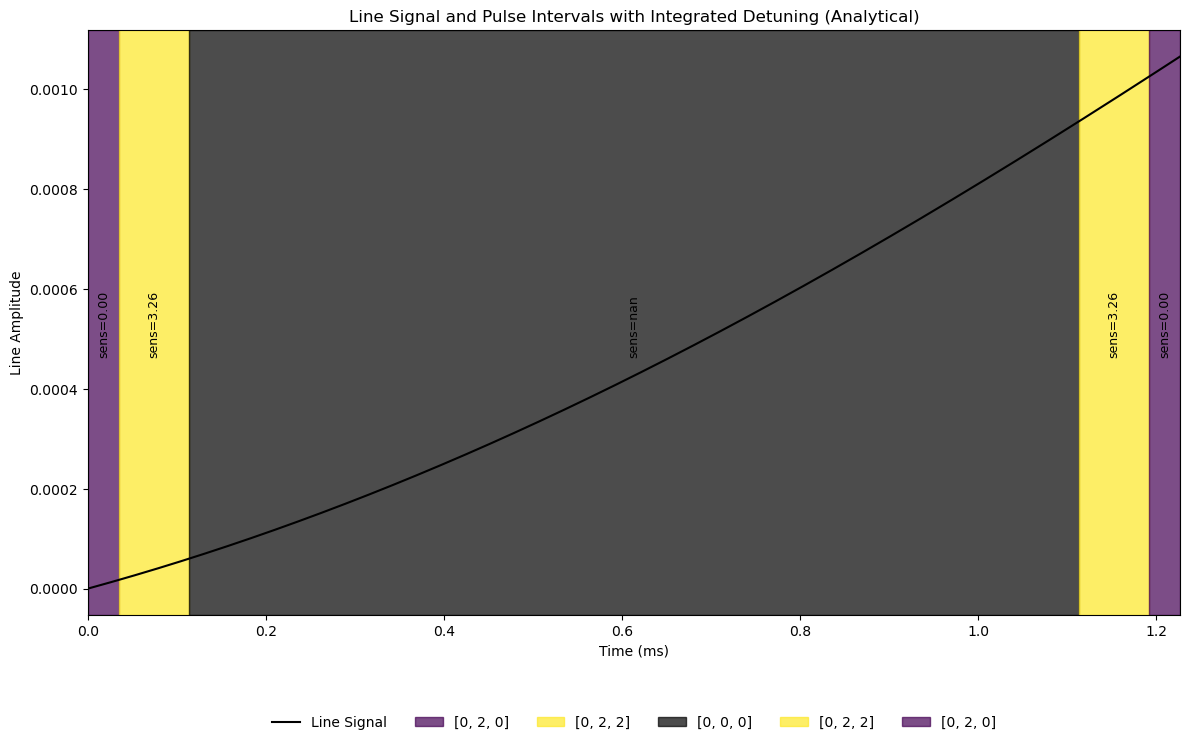

Midpoint line amplitudes for each pulse:
 [np.float64(8.513783305055724e-06), np.float64(3.798023692373428e-05), np.float64(0.0004261378987607035), np.float64(0.0009802195512723408), np.float64(0.0010452221005882107)]
Integrated values up to pulse start times (Analytical):
 [np.float64(0.0), np.float64(2.943632284105761e-10), np.float64(3.3071162197140087e-09), np.float64(4.5350379630784733e-07), np.float64(5.309026653920512e-07)]


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import viridis

def line_signal(t, 
                A1=0.000309, phi1=-0.613928,
                A2=0.000067, phi2=4.479853,
                offset=0.000253):
    return (
        2*np.pi*A1 * np.sin(2 * np.pi * 60 * t + phi1) +
        2*np.pi*A2 * np.sin(2 * np.pi * 180 * t + phi2) +
        offset
    ) - (
        2*np.pi*A1 * np.sin(2 * np.pi * 60 * 0 + phi1) +
        2*np.pi*A2 * np.sin(2 * np.pi * 180 * 0 + phi2) +
        offset
    )


def analytical_integral(T, 
                A1=0.000309, phi1=-0.613928,
                A2=0.000067, phi2=4.479853,
                offset=0.000253):

    int_60 = (A1 / 60) * (np.cos(phi1) - np.cos(2 * np.pi * 60 * T + phi1))

    int_180 = (A2 / 180) * (np.cos(phi2) - np.cos(2 * np.pi * 180 * T + phi2))

    t0 = (2 * np.pi * A1 * np.sin(2 * np.pi * 60 * 0 + phi1) +
            2 * np.pi * A2 * np.sin(2 * np.pi * 180 * 0 + phi2) +
            offset)

    int_offset = (offset - t0) * T
    return int_60 + int_180 + int_offset



# Assume get_pulse_schedule, rabi_frequencis_list, full_fractions, sens_list, and full_pulse_train are defined externally.
schedule = get_pulse_schedule(rabi_frequencis_list, full_fractions)
pulses_sec = [(start * 1e-6, end * 1e-6) for (start, end) in schedule]
t_min = 0.0
t_max = max(end for _, end in pulses_sec) if pulses_sec else 0.0

fs = 100_000
num_points = int(fs * (t_max - t_min)) if t_max > 0 else 1
if num_points < 2:
    num_points = 2

t_points = np.linspace(t_min, t_max, 3000)
line_signal_array = line_signal(t_points)

plt.figure(figsize=(12, 8))
plt.plot(t_points * 1e3, line_signal_array, 'k-', label='Line Signal')

# Normalize sensitivity values to map colors
norm_sens_list = np.abs(sens_list) / max(np.abs(sens_list))
cmap = viridis(norm_sens_list)

line_noise_amplitudes = []
integrated_values = []

for idx, (start_s, end_s) in enumerate(pulses_sec):
    plt.axvspan(
        start_s * 1e3, 
        end_s * 1e3,
        color=cmap[idx], 
        alpha=0.7,
        label=f'{full_pulse_train[idx]}'
    )
    
    # Skip pulses completely outside the time interval.
    if end_s < t_min:
        continue
    if start_s > t_max:
        break

    mid_point_s = 0.5 * (start_s + end_s)
    if t_min <= mid_point_s <= t_max:
        line_amp_mid = line_signal(mid_point_s)
    else:
        line_amp_mid = 0.0
    line_noise_amplitudes.append(line_amp_mid)

    # Replace numerical integration with the analytical integration up to start_s.
    partial_integral = analytical_integral(start_s)
    integrated_values.append(partial_integral)
    print("Analytical integral up to pulse start (s):", partial_integral)
    
    text_x_ms = mid_point_s * 1e3
    text_y = np.mean(line_signal_array)
    label_str = f"sens={sens_list[idx]:.2f}"
    plt.text(
        text_x_ms, 
        text_y, 
        label_str,
        ha='center', 
        va='bottom', 
        fontsize=9,
        color='black', 
        rotation=90
    )

plt.xlim(0, t_max * 1e3 if t_max > 0 else 1.0)
plt.xlabel("Time (ms)")
plt.ylabel("Line Amplitude")
plt.title("Line Signal and Pulse Intervals with Integrated Detuning (Analytical)")
plt.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15),
    ncol=7, 
    fontsize=10, 
    frameon=False
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("Midpoint line amplitudes for each pulse:\n", line_noise_amplitudes)
print("Integrated values up to pulse start times (Analytical):\n", integrated_values)
phase_180Hz = np.array(integrated_values)*1e6 * np.array(sens_list)